## Credit Card Feature Engineering

This project aims to explore different feature creation ideas from a corporate credit card transaction dataset to detect anomalies. Our analysis and brainstorming will imply a rule-based process for anomaly detection. The dataset is from Oklahoma State, showing the corporate credit card transactions from employees of the different agencies of the State of Oklahoma. In this context, anomalies might represent cardholders who abuse the use of their corporate cards (spending more in terms of both amount and frequency, spending excessively on weekends, etc.). We explore the Recency, Frequency, and Monetary Value (RFM) aspects of these transactions and engineer features on the basis of that. 

## Anomalies in Credit Card Transactions

Before we start getting into the data and the code, we first have to get through the "why" of this analysis. Why are we engineering features to find anomalies in credit card transactions? Why do anomalies matter? The answer is fraud. The theme of fraud may be common sense, but in doing a dive into a dataset like this, we can see at a more granular level how and what kinds of fraud might be done. We use both behavioral metrics and monetary value metrics to flag unusual transactions, which may or may not lead to fraud. This can only be determined through domain knowledge and further observations of the flagged transactions.

Fraud detection today is more vital than ever because of the massive move toward digital payments worldwide. The stakes are high because the stakeholders are everyone. On the institutional side, fraud causes financial harm, operational losses, security breaches, and an erosion of trust, all of which are terrible for the individual who uses the services of these financial institutions. Fraud does not just hurt the bank but may have ripple effects that hurt everyday consumers as well. As we move toward even newer payment channels, such as embedded payments and stablecoins, new safeguards will have to be added. This is the baseline for all of that. Let us get started.

## Load data and EDA

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

df = pd.read_csv("purchase_credit_card.csv")

print(df.head())
print(df.info())
print(df.describe())
print(df.isna().sum())

   Year-Month  Agency Number                Agency Name Cardholder Last Name  \
0      201307           1000  OKLAHOMA STATE UNIVERSITY                Mason   
1      201307           1000  OKLAHOMA STATE UNIVERSITY                Mason   
2      201307           1000  OKLAHOMA STATE UNIVERSITY               Massey   
3      201307           1000  OKLAHOMA STATE UNIVERSITY               Massey   
4      201307           1000  OKLAHOMA STATE UNIVERSITY        Mauro-Herrera   

  Cardholder First Initial                   Description  Amount  \
0                        C              GENERAL PURCHASE  890.00   
1                        C                  ROOM CHARGES  368.96   
2                        J              GENERAL PURCHASE  165.82   
3                        T              GENERAL PURCHASE   96.39   
4                        M  HAMMERMILL COPY PLUS COPY EA  125.96   

           Vendor        Transaction Date             Posted Date  \
0           NACAS  07/30/2013 12:00:00 AM

From here, nothing really sticks out. We have 0 NANs, and a wide range of spending amounts and frequencies. Moving on to the initial exploration for creating time fields (Day of week, time of day, etc.).

The first printout shows all times of the transaction date to be 00:00:00, or midnight. We confirm with the second line. It looks like we will not be able to create a time of day field, or any variable involving the time. We will then just create day/week based columns.

In [104]:
# Date prep
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])
df["Day of Week"] = df["Transaction Date"].dt.dayofweek
df["Weekend"] = df["Day of Week"].apply(lambda x: "Weekend" if x >= 5 else "Weekday") # --> binary column for weekend (1), and weekday (0)
df["Quarter"] = df["Transaction Date"].dt.quarter # --> divides the dates into Q1, Q2, Q3, Q4
df["Week_Number"] = df["Transaction Date"].dt.isocalendar().week # --> labels the weeks of the transactions
df["Year"] = df["Transaction Date"].dt.year # --> labels the year

/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_65242/1557830333.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])


These are good baselines for initial analyses/EDA. For the "Week" column, I opted for fixed weeks so all fluctuations are captured during the week, instead of smoothing later with a moving average. The latter approach might smooth out actual anomaly transactions during the week across multiple weeks. Because we are using the built-in week function, we will have 2 years' worth of the same week labels. We will have to pair it with the year column for it to be unique to the year. Below are some high-level plots for all agencies.

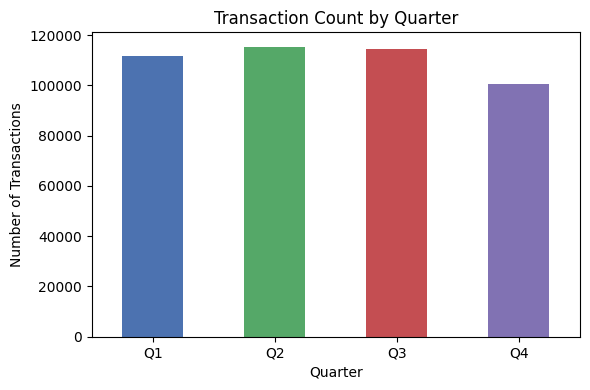

/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_65242/3965540000.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agency_daily_freq = df.groupby('Agency Name').apply(lambda g: g.shape[0] / g['Transaction Date'].dt.date.nunique())


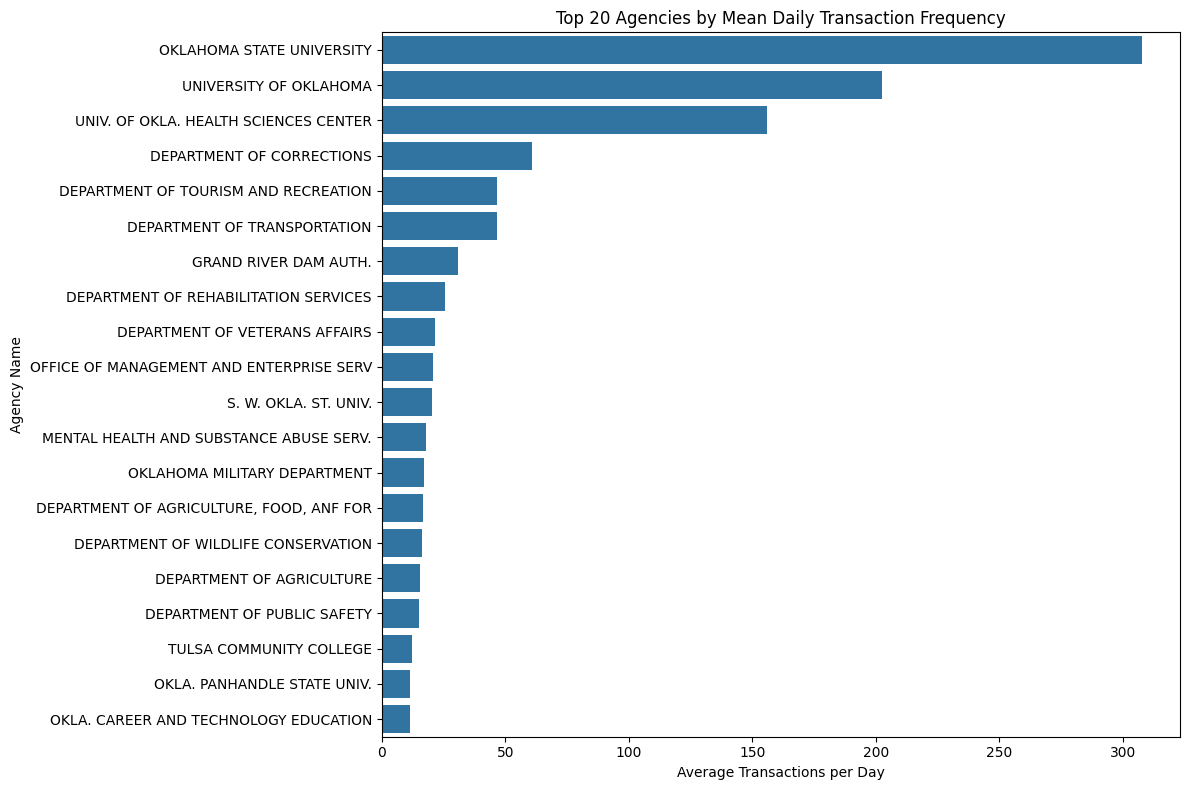

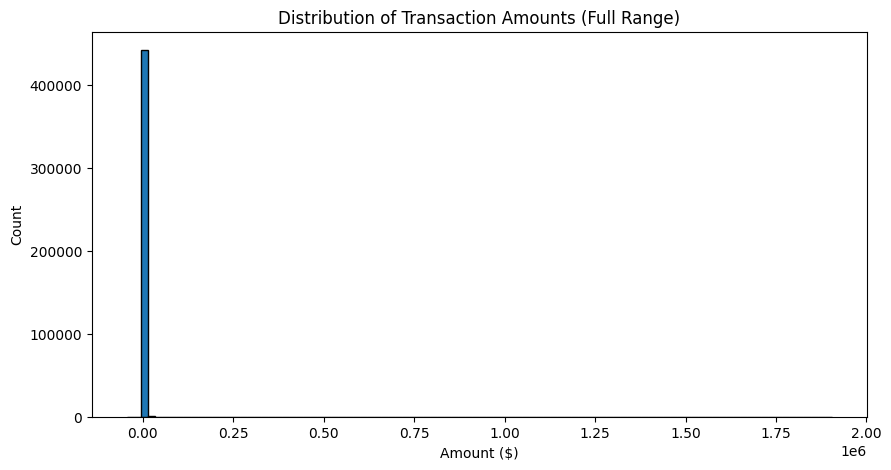

In [105]:
#Transaction frequency by quarter
plt.figure(figsize=(6,4))
quarter_counts = df.groupby('Quarter').size()
quarter_counts.plot(kind='bar', color=['#4C72B0','#55A868','#C44E52','#8172B3'])
plt.title('Transaction Count by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0,1,2,3], labels=['Q1','Q2','Q3','Q4'], rotation=0)
plt.tight_layout()
plt.show()

# Mean daily transaction frequency by agency
agency_daily_freq = df.groupby('Agency Name').apply(lambda g: g.shape[0] / g['Transaction Date'].dt.date.nunique())

# Get top 20 agencies by frequency
top_20_agencies = agency_daily_freq.sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_agencies.values, y=top_20_agencies.index)
plt.title('Top 20 Agencies by Mean Daily Transaction Frequency')
plt.xlabel('Average Transactions per Day')
plt.ylabel('Agency Name')
plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df["Amount"], bins=100, edgecolor='black')
plt.title("Distribution of Transaction Amounts (Full Range)")
plt.xlabel("Amount ($)")
plt.ylabel("Count")
plt.show()



Looking at it generally, the first plot shows a slight decline in Q4, possibly attributed to the bulk of holidays being in Q4. Overall, there weren't any visibly interesting trends here. The second plot gives frequency by the top 20 agencies, but this also does not tell us much, as it just reflects the number of people in each agency. As far as anomalies in credit cards go, it is unlikely that an entire agency will commit fraud or be suspicious, because those things happen at the individual level. As such, we will have to conduct analyses on the cardholder level. First, I make a unique key for each cardholder because people are likely to have both the same first names and surnames. This will just be a concatenation of the first letter of their names and their surnames. In the real world, two different people can still have the same first name letter and surname, but since we have no other identifier, this will have to do.

The third plot is just a simple distribution plot of the amount column. This is important because we will be creating a lot of features that use this column as the underlying information. For the plot itself, this is not a great plot to look at, particularly because of the distribution. It's very difficult to see here, but the bulk of our transactions all cluster around a very tight range. Outside of that range however, we have a very diverse range of monetary values transacted, all the way up to $1.9M. Let's zoom in further.

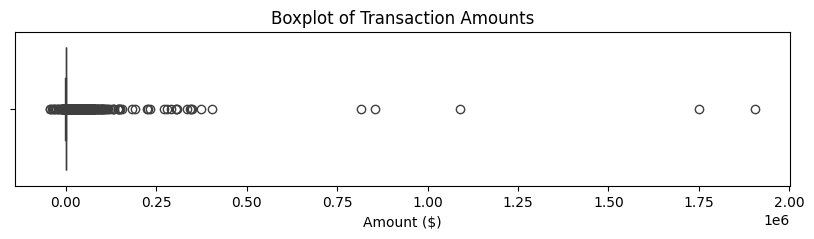

0.00      -42,863.04
0.01         -166.00
0.05            4.95
0.25           30.91
0.50          104.89
0.75          345.00
0.95        1,487.13
0.99        4,298.57
1.00    1,903,858.37
Name: Amount, dtype: object


In [106]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=df["Amount"])
plt.title("Boxplot of Transaction Amounts")
plt.xlabel("Amount ($)")
plt.show()

percentiles = df["Amount"].quantile([0, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1.0])
formatted = percentiles.apply(lambda x: f"{x:,.2f}")
print(formatted)


After observing the boxplot and the percentiles, we confirm our suspicion of the extreme ranges of this column. It looks like 95% of the amounts are actually below $1500, but we have values that go up much further, and values that go below 0. This is no surprise. The data reflects real life, where corporate credit card spend is used for everything from buying a sandwich to very expensive purchases like equipment, travel expenses, or institutional fees. If we cap the histogram at the 95th percentile, the data is more visually digestible.

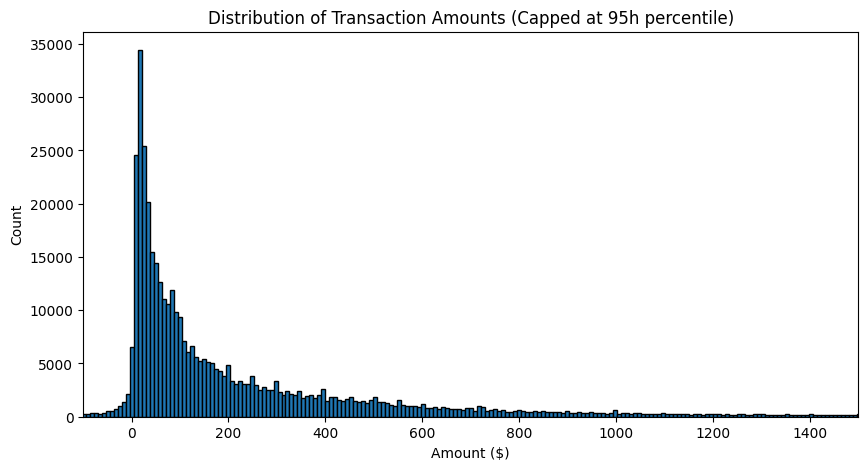

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df["Amount"], bins = 'auto',edgecolor='black')
plt.xlim(-100, 1500)
plt.title("Distribution of Transaction Amounts (Capped at 95h percentile)")
plt.xlabel("Amount ($)")
plt.ylabel("Count")
plt.show()


In [108]:
df["cardholder_full_name"] = df["Cardholder First Initial"] + " " + df["Cardholder Last Name"]
print(df["cardholder_full_name"].nunique())

5213


We then want to check the count of unique cardholders, to investigate whether we can construct cardholder-centric features. There are 5213 unique combinations of first and last names, so this makes it harder to plot and look at distributions. We will have to rely on deviation based features, where we will make benchmarks for each cardholder and analyze deviations to that benchmark.

### Feature 1 - Mean transaction amounts for each cardholder

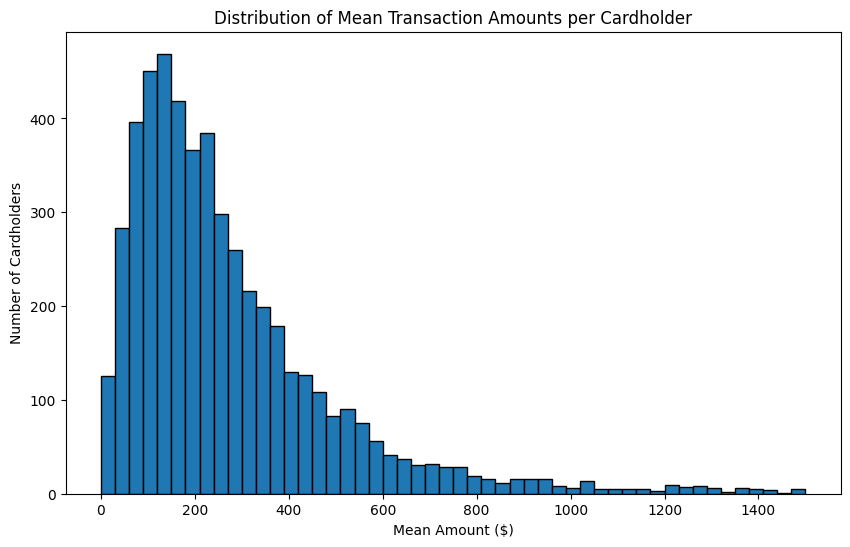

In [109]:
df_model = df.copy()
df_model["Amount Mean"] = df_model.groupby(["cardholder_full_name"])["Amount"].transform("mean")

#plot
cardholder_means = df.groupby("cardholder_full_name")["Amount"].mean()

plt.figure(figsize=(10, 6))
plt.hist(cardholder_means, bins=50, range=(0, 1500), edgecolor='black')
plt.title("Distribution of Mean Transaction Amounts per Cardholder")
plt.xlabel("Mean Amount ($)")
plt.ylabel("Number of Cardholders")
plt.show()


This feature is a simple yet powerful behavioral measure, mainly as a benchmark. Since this mean is specific for the week number, you can measure the current transaction, or line, to this mean number to get a sense of whether it is close to the mean, or whether it is dragging this mean up or down. This is a cardholder specific feature, so it is a better measure of habits then just a general mean.

### Feature 2 - Weekly transaction counts for each cardholder

count    442458.000000
mean         15.488512
std          33.776756
min           1.000000
25%           2.675000
50%           4.705882
75%          10.365385
max         187.722222
Name: mean_tx_per_week, dtype: float64


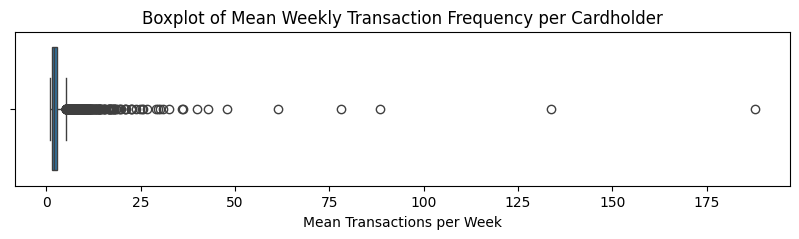

In [110]:
#transactions per week per cardholder
weekly_counts = df.groupby(["cardholder_full_name", "Year", "Week_Number"]).size().reset_index(name="weekly_tx_count")

#average weekly frequency per cardholder
mean_weekly_freq = weekly_counts.groupby("cardholder_full_name")["weekly_tx_count"].mean().reset_index(name="mean_tx_per_week")

#add back into original dataframe
df_model = df_model.merge(mean_weekly_freq, on="cardholder_full_name", how="left")

print(df_model["mean_tx_per_week"].describe())


plt.figure(figsize=(10, 2))
sns.boxplot(x=mean_weekly_freq["mean_tx_per_week"])
plt.title("Boxplot of Mean Weekly Transaction Frequency per Cardholder")
plt.xlabel("Mean Transactions per Week")
plt.show()

Unlike the first feature, we now want to observe weekly habits. This is not a mean, but rather an aggregation of the weekly transaction frequencies. Independent to the amount spent, a spike in frequency is a good indicator for fraud and misuse. This feature, like feature 1, will also drive the creation of the percentile features, which they will be measured against.

### Feature 3 - 90th and 95th percentile of transaction amount

In [112]:
# Compute per-person 90th and 95th percentile thresholds on their raw transaction amounts
amount_90th = df_model.groupby("cardholder_full_name")["Amount"].transform(lambda x: x.quantile(0.9))
amount_95th = df_model.groupby("cardholder_full_name")["Amount"].transform(lambda x: x.quantile(0.95))

# Flag each transaction above that person’s threshold
df_model["Amount_Above_90th"] = (df_model["Amount"] > amount_90th).astype(int)
df_model["Amount_Above_95th"] = (df_model["Amount"] > amount_95th).astype(int)

# Count repeat offenders
repeat_90th = (
    df_model[df_model["Amount_Above_90th"] == 1]
    .groupby("cardholder_full_name")["Amount_Above_90th"]
    .count()
    .sort_values(ascending=False)
)

repeat_95th = (
    df_model[df_model["Amount_Above_95th"] == 1]
    .groupby("cardholder_full_name")["Amount_Above_95th"]
    .count()
    .sort_values(ascending=False)
)

# Display top offenders
print("Top repeat offenders above 90th percentile:\n")
print(repeat_90th.head(10))

print("\nTop repeat offenders above 95th percentile:\n")
print(repeat_95th.head(10))


Top repeat offenders above 90th percentile:

cardholder_full_name
G JOURNEY HOUSE TRAVEL INC    1014
G UNIVERSITY AMERICAN          719
G JOURNEY HOUSE TRAVEL         469
J Heusel                       422
G Hines                        331
R Bowers                       245
M Tornakian                    227
K MCDOWELL                     212
A HANNAH                       196
P Stroup                       194
Name: Amount_Above_90th, dtype: int64

Top repeat offenders above 95th percentile:

cardholder_full_name
G JOURNEY HOUSE TRAVEL INC    496
G UNIVERSITY AMERICAN         360
G JOURNEY HOUSE TRAVEL        234
J Heusel                      211
G Hines                       166
R Bowers                      123
M Tornakian                   114
K MCDOWELL                    103
A HANNAH                       98
P Stroup                       97
Name: Amount_Above_95th, dtype: int64


This feature is very simple and straightforward, and it is just meant to flag which weeks' spending amounts exceed a given cardholder's 90th and 95th percentile. This column isolates cases where cardholders spend in their top 10% or 5% of their norm. The rationale for picking different percentiles is the sensitivity, where the 90th percentile would represent moderate anomalies, and 95th would be the edge cases. As seen in our prior distribution for amount, we have an extremely long right tail. Therefore, attributing to specific cardholders may highlight more insight. We zoom in even further to the top cardholder. 

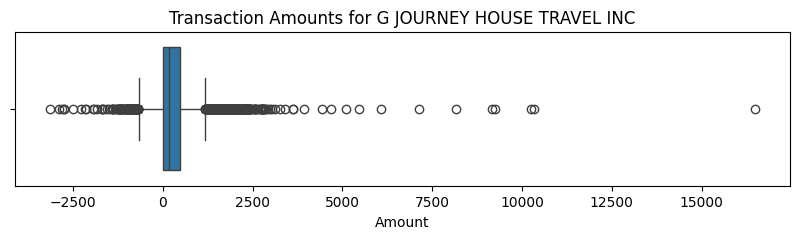

count    10137.000000
mean       289.078843
std        533.340907
min      -3136.060000
25%         20.000000
50%        177.800000
75%        484.000000
max      16474.000000
Name: Amount, dtype: float64


In [114]:
#filter for top cardholder
top_cardholder = "G JOURNEY HOUSE TRAVEL INC"
subset = df_model[df_model["cardholder_full_name"] == top_cardholder]

#boxplot
plt.figure(figsize=(10, 2))
sns.boxplot(x=subset["Amount"])
plt.title(f"Transaction Amounts for {top_cardholder}")
plt.xlabel("Amount")
plt.show()

#summary stats
print(subset["Amount"].describe())


Now the 1014 transactions above this cardholder's 90th percentile make more sense. This particular cardholder has 10137 transactions with a standard deviation of $533. That is significant variability. Before we flag this for anything, we have to ask what these numbers mean, practically. The initial hypothesis would be that this cardholder is not an individual, but rather an entire department or an organization. The supporting evidence is in the heavy volume, but also the high variance and the long tail. This is where anomaly detection in credit cards involves more art than science. We've flagged it with our metrics, but we now have to decide whether this is suspicious or not.

### Feature 4 - Ratio of current week's transaction count to mean transactions per week

In [116]:
#frequency ratio
weekly_counts["frequency_ratio"] = weekly_counts["weekly_tx_count"] / weekly_counts["mean_tx_per_week"]

#pick 2x as flag
weekly_counts["freq_ratio_gt_2"] = (weekly_counts["frequency_ratio"] > 2).astype(int)

#identify top repeat offenders
top_offenders = (
    weekly_counts[weekly_counts["freq_ratio_gt_2"] == 1]
    .groupby("cardholder_full_name")["freq_ratio_gt_2"]
    .count()
    .sort_values(ascending=False)
    .head(10)
)

print("Top cardholders with most weeks >2x their average weekly transaction frequency:\n")
print(top_offenders)

Top cardholders with most weeks >2x their average weekly transaction frequency:

cardholder_full_name
O FOSTER        11
G Martin        10
D OTIS          10
A JONES         10
B LARSON         9
L Darnell        9
J Cartwright     9
K WALKER         9
S Knott          9
R Keithley       9
Name: freq_ratio_gt_2, dtype: int64


We can apply the same analytic logic from feature 3 to feature 4, but the key here is quite simple. Credit card fraud is often signaled by an increase in frequency and diversity of vendors. This feature gives us a good glimpse into spikes in credit card use, and again, it is personalized to work per cardholder. We do not use a global frequency count for everyone. We picked 2x as the flag threshold here, but the multiple is meant to be a good tuning knob. If we wanted to see 4x, we can just change it like the below.

In [117]:
#pick 4x as flag
weekly_counts["freq_ratio_gt_4"] = (weekly_counts["frequency_ratio"] > 4).astype(int)

#identify top repeat offenders 4x
top_offenders = (
    weekly_counts[weekly_counts["freq_ratio_gt_4"] == 1]
    .groupby("cardholder_full_name")["freq_ratio_gt_4"]
    .count()
    .sort_values(ascending=False)
    .head(10)
)

print("Top cardholders with most weeks >4x their average weekly transaction frequency:\n")
print(top_offenders)

Top cardholders with most weeks >4x their average weekly transaction frequency:

cardholder_full_name
A McFadden        3
S Hawkins         3
T STUBBLEFIELD    3
D Connelly        3
R Gaskamp         3
A Batenhorst      3
S Longan          2
M Coponiti        2
R Gnagy           2
M SISCO           2
Name: freq_ratio_gt_4, dtype: int64


Now we have completely different people in our list, and the number of weeks that they meet this threshold is also much less. With adequate domain knowledge, we can determine that it is now more probable that this list is full of stronger anomalies.

### Feature 5 - Diversity of vendors per week

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
count    442458.000000
mean          1.000000
std           0.474614
min           0.019823
25%           0.657083
50%           0.950096
75%           1.270110
max           5.029666
Name: Vendor_Diversity_Ratio, dtype: float64


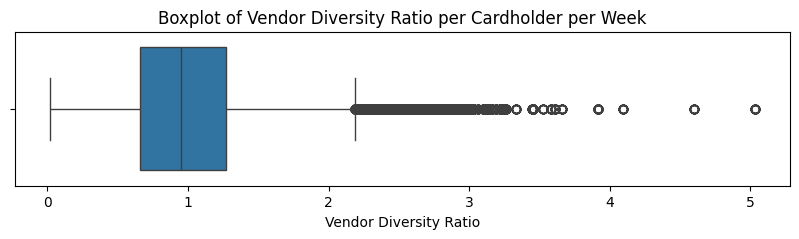

In [118]:
weekly_vendor_count = df_model.groupby(["cardholder_full_name", "Year", "Week_Number"])["Vendor"].nunique()
df_model["Weekly_Unique_Vendors"] = df_model.set_index(["cardholder_full_name", "Year", "Week_Number"]).index.map(weekly_vendor_count)

#compare to user's average as ratio
user_vendor_mean = df_model.groupby("cardholder_full_name")["Weekly_Unique_Vendors"].transform("mean")
df_model["Vendor_Diversity_Ratio"] = df_model["Weekly_Unique_Vendors"] / user_vendor_mean


# Summary statistics
print(df_model["Vendor_Diversity_Ratio"].describe())

# Boxplot
plt.figure(figsize=(10, 2))
sns.boxplot(x=df_model["Vendor_Diversity_Ratio"])
plt.title("Boxplot of Vendor Diversity Ratio per Cardholder per Week")
plt.xlabel("Vendor Diversity Ratio")
plt.show()

Feature 5 is a measure of the different unique vendors that a cardholder transacts with for the period of one week, each week. The second block shows how we can use it as a flag for anomalies by comparing the current weekly number to the cardholder's historical mean. In the context of the dataset, deviations here might signal theft or fraud, where the user will interact with many different and likely new vendors. This feature is also behavioral in nature. When we look at the summary statistics and the boxplot, most transactions have a mean of 1, which makes sense since we are comparing the vendor diversity of each cardholder for each week to their own means. The interesting parts are the data points above the 75th percentile, with a max ratio of 5x. That is very high and could be a sign of fraud.

### Feature 6 - Weekly Spend Proportion

In [37]:
# Calculate total and weekend spend for each group
group_keys = ['cardholder_full_name', 'Year', 'Week_Number']

total_weekly = df_model.groupby(group_keys)['Amount'].transform('sum')

weekend_weekly = df_model.where(df_model['Weekend'] == 'Weekend').groupby(group_keys)['Amount'].transform('sum').fillna(0)

df_model['Weekly_Weekend_Spend_Proportion'] = np.where(
    total_weekly == 0,
    0,
    weekend_weekly / total_weekly
)

Feature 9 identifies what portion of a user’s spending takes place on weekends. In government or institutional credit card contexts, weekend purchases can be restricted or require justification. Users who historically have no weekend activity but suddenly exhibit weekend spend behavior could be flagged for further review.

### Feature 7 - Round Numbers

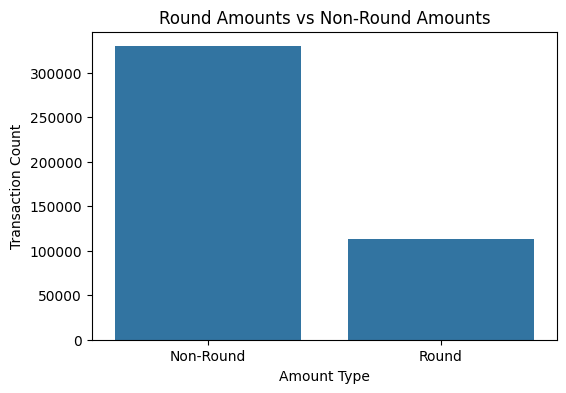

Proportion of round amounts: 0.2550


In [120]:
df_model['Is_Round_Amount'] = ((df_model['Amount'] % 1 == 0) & (df_model['Amount'] > 0)).astype(int)

# Count plot of round vs non-round
plt.figure(figsize=(6, 4))
sns.countplot(x='Is_Round_Amount', data=df_model)
plt.title('Round Amounts vs Non-Round Amounts')
plt.xticks([0, 1], ['Non-Round', 'Round'])
plt.ylabel('Transaction Count')
plt.xlabel('Amount Type')
plt.show()

round_ratio = df_model['Is_Round_Amount'].mean()
print(f"Proportion of round amounts: {round_ratio:.4f}")

Feature 10 is a very simple binary measure of whether the transaction is a round number or not. The rationale behind this is that gift cards, a common fraudulent money transfer tool, come in round numbers. Of course, other transactions might come in round numbers as well, so this variable is only meant to be a supporting variable to the others before it. It looks like approximately 25% of our transactions are round amounts, which may or may not mean anything. We can use this in tandem with the previous features above and come up with a sharper conclusion.